[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/peteyeh/celltrack/HEAD?labpath=feature_extraction.ipynb)

In [1]:
%matplotlib inline

import cv2
import imageio
import matplotlib.colors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import seaborn as sns

from collections import Counter
from joblib import cpu_count, delayed, Parallel
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

from displaytools import *
from improcessing import *
from rfextraction import *

# Read in image file

In [2]:
image_stack = cv2.imreadmulti('source_images/Control.tif', flags=cv2.IMREAD_GRAYSCALE)[1]

# Extract mask image

Using mode 'thresh_manual'.
Denoising with intensity 3.
Enhancing contrast by factor of 100.00, with offset=-12 and preserve_background=False.
Manually thresholding on values >=1.
Unmasking areas without edges using Canny[130, 180]:
Removing border of 1 pixels.
Closing with kernel size of 2.
Unmasking regions smaller than 30 pixels.


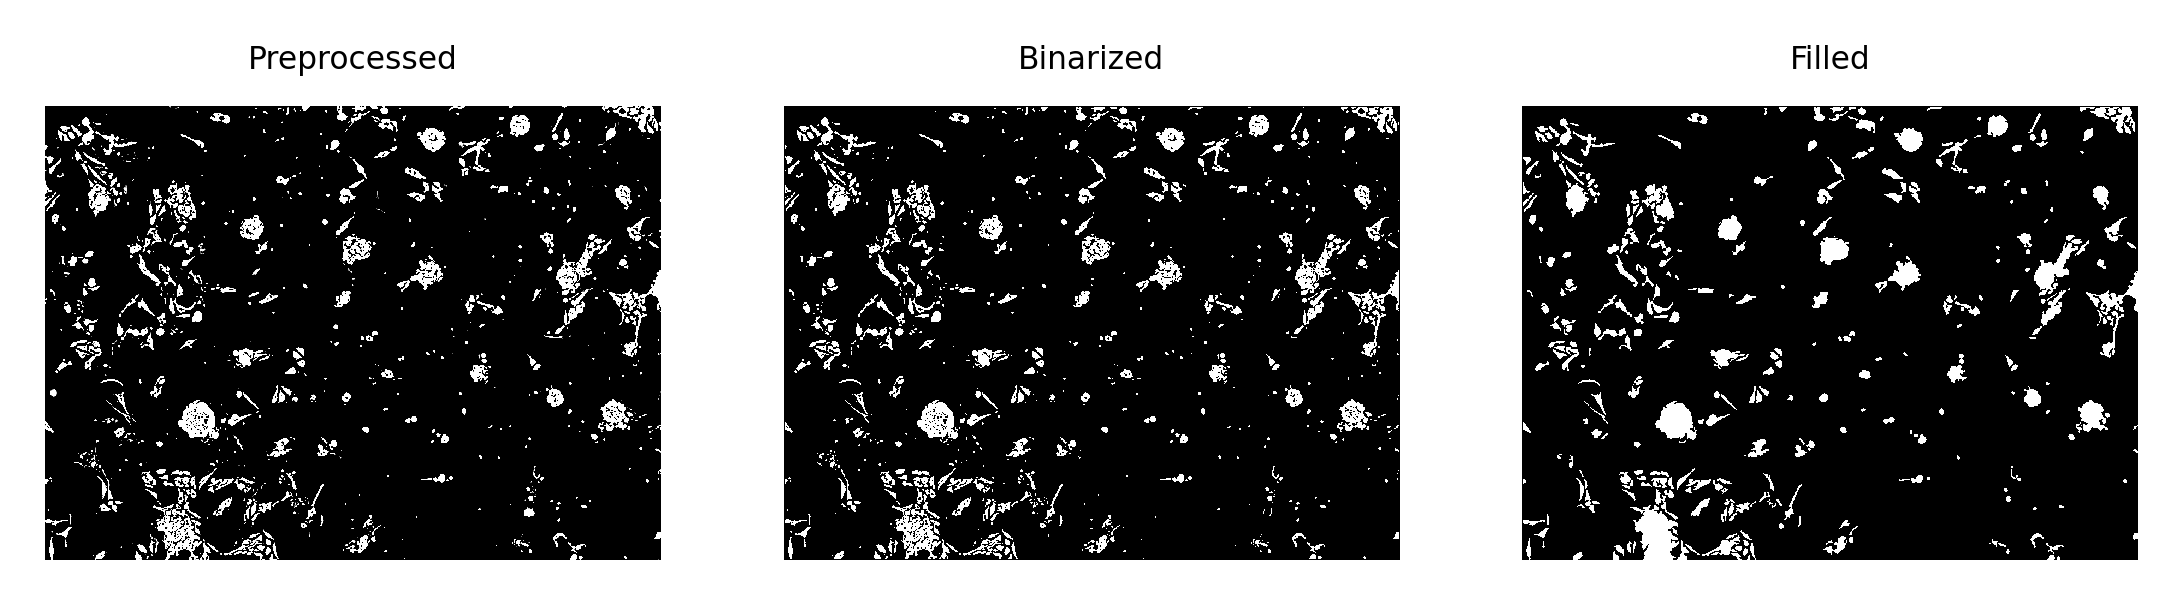

In [3]:
image_gray = scale_image(image_stack[0])
mask_image = get_mask_image(image_gray, 'params_gray_mask.yml', verbosity=2)

# Extract features, then standardize and reduce dimensions

In [4]:
df, mask_labels = extract_features(image_gray, mask_image)
display(df)

original_shape2D_Elongation  original_shape2D_MajorAxisLength  \
x   y                                                                    
445 9                       0.266277                         16.589251   
476 4                       0.640217                         13.993025   
542 15                      0.544798                         29.896998   
576 5                       0.374940                         24.295006   
604 3                       0.336838                         14.604395   
...                              ...                               ...   
170 825                     0.662439                         16.577199   
393 824                     0.425099                         20.391189   
415 827                     0.450064                         11.384014   
969 827                     0.782803                         13.488030   
981 828                     0.951069                          7.512348   

        original_shape2D_MaximumDiameter original_shape2D_MeshSurface  \
x   y                                                                   
445 9                 14.317821063276353                         44.5   
476 4                 15.297058540778355                         86.5   
542 15                29.154759474226502                        312.5   
576 5                 25.179356624028344                        156.5   
604 3                 13.341664064126334                         52.5   
...                                  ...                          ...   
170 825               18.027756377319946                        126.5   
393 824                21.95449840010015                        106.5   
415 827               11.180339887498949                         42.5   
969 827               14.866068747318506                        103.5   
981 828                 8.06225774829855                         41.5   

         original_shape2D_MinorAxisLength original_shape2D_Perimeter  \
x   y                                                                  
445 9                            4.417328          36.97056274847713   
476 4                            8.958573           39.7989898732233   
542 15                          16.287831          89.01219330881982   
576 5                            9.109165          66.04163056034258   
604 3                            4.919320         33.656854249492376   
...                                   ...                        ...   
170 825                         10.981375          49.55634918610403   
393 824                          8.668278         59.455844122715675   
415 827                          5.123536          28.48528137423856   
969 827                         10.558472         42.142135623730944   
981 828                          7.144762          24.48528137423857   

        original_shape2D_PerimeterSurfaceRatio  original_shape2D_PixelSurface  \
x   y                                                                           
445 9                       0.8307991628871265                           45.0   
476 4                      0.46010392917021153                           87.0   
542 15                      0.2848390185882234                          313.0   
576 5                       0.4219912495868536                          157.0   
604 3                        0.641082938085569                           53.0   
...                                        ...                            ...   
170 825                    0.39174979593758125                          127.0   
393 824                      0.558270836833011                          107.0   
415 827                     0.6702419146879661                           43.0   
969 827                     0.4071703924998159                          104.0   
981 828                     0.5900067801021343                           42.0   

         original_shape2D_Sphericity original_firstorder_10Percentile  ...  \
x   y                      

In [5]:
scaler = StandardScaler()
pca = PCA(n_components='mle')

scaled = scaler.fit_transform(df)
dft = pd.DataFrame(pca.fit_transform(scaled), index=df.index)
display(dft)

0         1         2         3         4         5   \
x   y                                                                  
445 9   -13.531150 -2.256091  4.553934  1.318294 -0.723097  2.178023   
476 4     2.512691 -3.022413 -0.913692  1.780301 -1.610264 -0.064655   
542 15    4.168416  2.390337 -2.699581 -0.889774  0.032551 -1.058272   
576 5     2.207096  0.660801 -2.716922  1.611136  3.224126  0.798857   
604 3    -3.769760 -4.543060  2.517080  0.406545 -2.300247  0.725307   
...            ...       ...       ...       ...       ...       ...   
170 825  -7.591266  1.163675 -0.257515  2.055273  2.117611 -2.335483   
393 824  -0.333556 -0.204145 -0.764656 -1.678265  0.801513 -1.925620   
415 827  -4.214894 -3.206216  1.358024 -0.672965 -1.183700 -1.049309   
969 827   7.017325 -3.628605 -1.696538  3.246482  2.391450 -1.047588   
981 828   8.587601 -8.039213  0.594570  1.596217 -0.852145  2.047166   

               6         7         8         9   ...        87        88  \
x   y                                            ...                       
445 9   -1.881599 -1.051173  0.268270 -2.828532  ... -0.016751  0.016987   
476 4   -0.420394 -0.096061  2.590934 -0.066468  ... -0.001552  0.008555   
542 15  -0.494286 -0.221353 -0.441520 -0.697717  ... -0.008946 -0.003712   
576 5    0.284355 -1.114577  0.296641  1.203853  ...  0.008387  0.005785   
604 3   -0.925352 -0.426002  0.920532 -0.480567  ...  0.017286  0.001705   
...           ...       ...       ...       ...  ...       ...       ...   
170 825  0.431328  2.291298 -0.589368  0.297704  ...  0.017255 -0.003754   
393 824 -0.448190  0.437002  0.586140 -0.263344  ... -0.005199  0.023796   
415 827  0.317531  0.058836  1.724400 -0.367658  ... -0.013916 -0.017669   
969 827 -0.014002  0.590369  0.050255 -1.743787  ...  0.006594 -0.026366   
981 828  1.347697  1.136307  0.294333 -2.560546  ...  0.030399 -0.012366   

               89        90        91        92        93        94        95  \
x   y                                                                           
445 9    0.012420 -0.005804  0.020148  0.004538 -0.014231  0.001236 -0.000064   
476 4    0.001952 -0.015029  0.006052  0.009455  0.006905 -0.000686 -0.000070   
542 15  -0.013090  0.029667  0.004048 -0.001481 -0.005782  0.000746 -0.000035   
576 5    0.014507 -0.008674  0.022637  0.008699 -0.002809 -0.004669 -0.000046   
604 3   -0.005271 -0.001268 -0.007356  0.013117 -0.009061  0.000270  0.000099   
...           ...       ...       ...       ...       ...       ...       ...   
170 825 -0.033297 -0.017108  0.009662  0.012361 -0.001294  0.000742  0.000117   
393 824  0.002212 -0.005516  0.018025  0.005973  0.003004 -0.002242 -0.000178   
415 827  0.023020  0.009032  0.011096 -0.009351 -0.008864  0.002262 -0.000058   
969 827  0.009464  0.042345 -0.004734 -0.023898  0.016174  0.005787 -0.000029   
981 828  0.022091 -0.009120 -0.014036 -0.004165 -0.006118 -0.000026  0.000040   

               96  
x   y              
445 9    0.000008  
476 4    0.000004  
542 15  -0.000019  
576 5   -0.000044  
604 3   -0.000015  
...           ...  
170 825 -0.000005  
393 824 -0.000009  
415 827 -0.000002  
969 827  0.000023  
981 828  0.000016  

[317 rows x 97 columns]

# Determine number of clusters

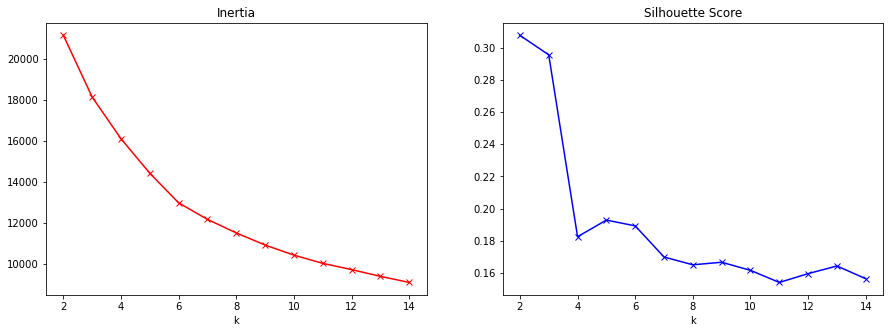

In [6]:
inertias = []
silhouette_scores = []
k_range = range(2, 15)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=0)
    labels = kmeans.fit_predict(dft)
    inertias += [kmeans.inertia_,]
    silhouette_scores += [silhouette_score(dft, labels),]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
ax1.plot(k_range, inertias, 'rx-')
ax1.set(xlabel='k', title="Inertia")
ax2.plot(k_range, silhouette_scores,'bx-')
ax2.set(xlabel='k', title="Silhouette Score")
plt.show()

## User-defined values

In [7]:
# Manually select k based on visual inspection above
global_k = 6

# Classification colors (include k colors, or use colormap string)
colormap = matplotlib.colors.ListedColormap(['yellow', 'red', 'cyan', 'orange', 'green', 'purple'])

# Fit and classify using k-means

In [8]:
kmeans = KMeans(n_clusters=global_k, random_state=0)
labels = kmeans.fit_predict(dft)
print_label_counts(labels, colormap)

Class 0 (yellow): 8 (2.52%)
Class 1 (red): 91 (28.71%)
Class 2 (cyan): 41 (12.93%)
Class 3 (orange): 53 (16.72%)
Class 4 (green): 69 (21.77%)
Class 5 (purple): 55 (17.35%)


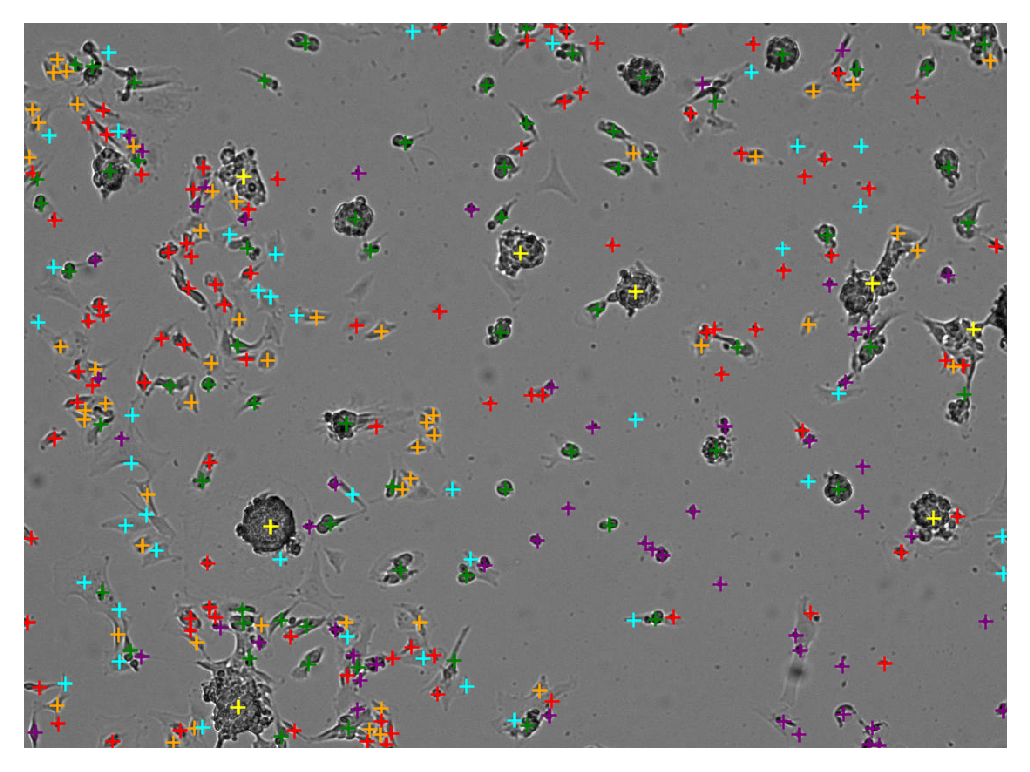

In [9]:
display_classifications(image_gray, dft.index, labels, colormap)

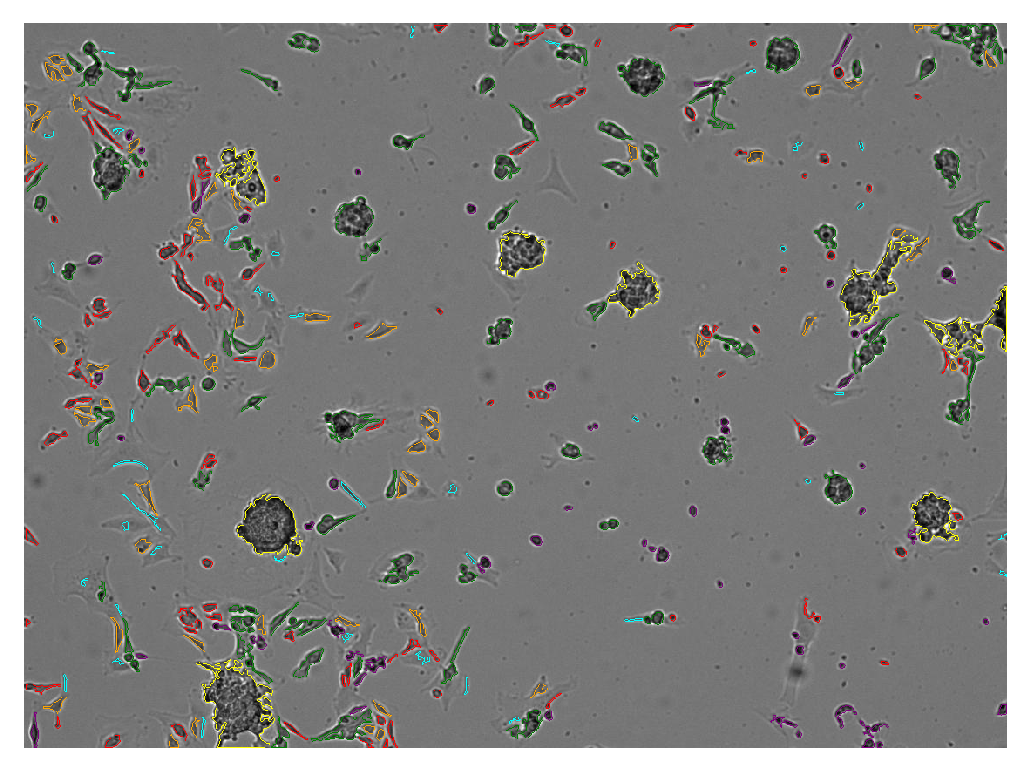

In [10]:
display_image(get_contoured_image(image_gray, mask_labels, labels, colormap))

Unfortunately `sklearn` doesn't let us set a colormap here so disregard the inconsistent coloring.

/Users/peteyeh/miniconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


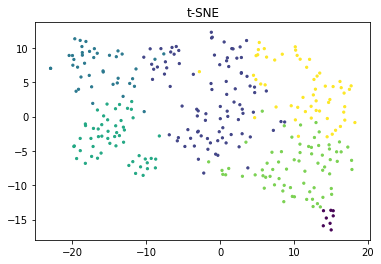

In [11]:
display_tsne(dft, labels)

# Estimate feature importance

In [12]:
num_features = 3

for k in range(labels.max()+1):
    y = np.uint8(labels==k)
    lr = LogisticRegression().fit(scaled, y)
    sorted_features = [(y, x) for x, y in sorted(zip(lr.coef_[0], df.columns))]
    print("Class %i:" % k)
    for feature, coeff in sorted_features[-num_features:]:
        print("  %s: %.3f" % (feature.replace("original_", ""), coeff))
    print("  ...")
    for feature, coeff in reversed(sorted_features[:num_features]):
        print("  %s: %.3f" % (feature.replace("original_", ""), coeff))

Class 0:
  shape2D_MinorAxisLength: 0.352
  gldm_DependenceNonUniformity: 0.363
  glrlm_RunLengthNonUniformity: 0.368
  ...
  glszm_LargeAreaEmphasis: -0.086
  glszm_ZoneVariance: -0.101
  glszm_LargeAreaHighGrayLevelEmphasis: -0.154
Class 1:
  glrlm_ShortRunEmphasis: 0.786
  gldm_DependenceVariance: 0.790
  glcm_DifferenceEntropy: 1.151
  ...
  ngtdm_Complexity: -1.136
  glrlm_GrayLevelNonUniformityNormalized: -1.161
  gldm_SmallDependenceHighGrayLevelEmphasis: -1.433
Class 2:
  ngtdm_Contrast: 0.377
  glszm_SmallAreaLowGrayLevelEmphasis: 0.417
  shape2D_PerimeterSurfaceRatio: 0.594
  ...
  glszm_ZoneEntropy: -0.684
  glszm_LargeAreaHighGrayLevelEmphasis: -0.690
  glszm_ZonePercentage: -0.824
Class 3:
  glrlm_RunVariance: 0.574
  glszm_ZoneVariance: 0.625
  gldm_DependenceVariance: 0.928
  ...
  shape2D_PerimeterSurfaceRatio: -0.669
  gldm_DependenceNonUniformityNormalized: -0.727
  ngtdm_Coarseness: -0.848
Class 4:
  glszm_ZoneEntropy: 0.763
  gldm_LargeDependenceHighGrayLevelEmphasi

# Classify whole image stack

In [13]:
gray_images = image_stack

# gray_images = list(map(scale_image, image_stack[1::3]))
# fluor_images_1 = image_stack[0::3]
# fluor_images_2 = image_stack[2::3]
# max_1 = np.array(fluor_images_1).max()
# max_2 = np.array(fluor_images_2).max()

## Sanity check mask images

In [14]:
def mi_parallel(image_gray):
    return get_mask_image(image_gray, 'params_gray_mask.yml')

In [15]:
# mask_images = Parallel(n_jobs=cpu_count())(delayed(mi_parallel)(ig) for ig in tqdm(gray_images))
# display_image_array(mask_images, columns=9, dpi=300)

## Extract raw features in parallel

`get_mask_image` and `extract_features` are the most computationally expensive operations, and conveniently are also very easy to parallelize.

This cuts down runtime by >50%. Note that `tqdm` tracks process initiation, not completion, but this is a cheap and easy way to track progress.

In [16]:
def ef_parallel(image_gray):
    mask_image = get_mask_image(image_gray, 'params_gray_mask.yml')
    df, mask_labels = extract_features(image_gray, mask_image)
    return df, mask_labels

In [17]:
result = Parallel(n_jobs=cpu_count())(delayed(ef_parallel)(ig) for ig in tqdm(gray_images))

100%|████████████████████████████████████████████████| 144/144 [30:17<00:00, 12.62s/it]


## Pickle result in case kernel is lost
This takes up ~2GB on disk with `suspension_colour.tiff`, so don't do this automatically.

In [18]:
# with open("result.pickle", "wb") as outfile:
#     pickle.dump(result, outfile)

# with open("result.pickle", "rb") as infile:
#     result = pickle.load(infile)

## Process features, cluster using k-means, extract analysis data

This expects that the models have been trained in the cells above - we'll re-transform the first image but that's okay.

In [19]:
def esf_parallel(k, labels, mask_labels):
    masks = np.array([np.uint8(mask_labels==idx) for idx in np.where(labels==k)[0]+1])
    sizes = list(map(np.sum, masks))
    return np.sum(sizes), int(np.mean(sizes))

# def esf_parallel(k, labels, mask_labels, flr_image_1, flr_image_2, max_1, max_2):
#     masks = np.array([np.uint8(mask_labels==idx) for idx in np.where(labels==k)[0]+1])
#     sizes = list(map(np.sum, masks))
#     combined_mask = np.bitwise_or.reduce(masks, axis=0)
#     # do some magic arithmetic here to handle 0 values
#     combined_mask = np.int16(combined_mask) * 2 - 1
#     c1 = Counter(((combined_mask * (np.int16(flr_image_1)+5))-5).flatten())
#     c2 = Counter(((combined_mask * (np.int16(flr_image_2)+5))-5).flatten())
#     intensities = [c1[a] for a in range(max_1)], [c2[a] for a in range(max_2)]
#     return np.sum(sizes), int(np.mean(sizes)), np.array(intensities, dtype=int)

Image 0:


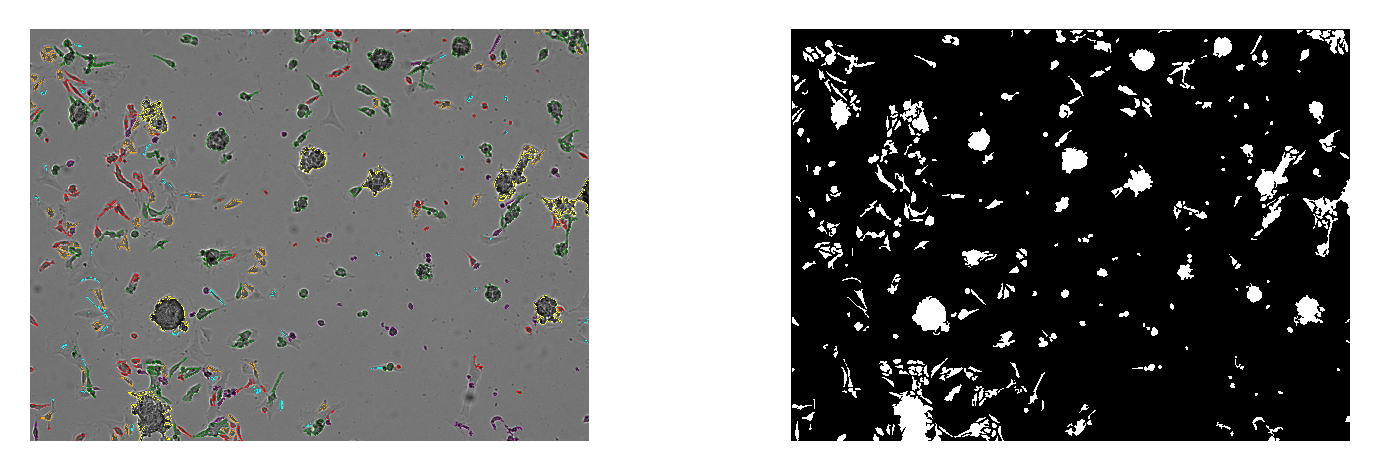

Image 15:


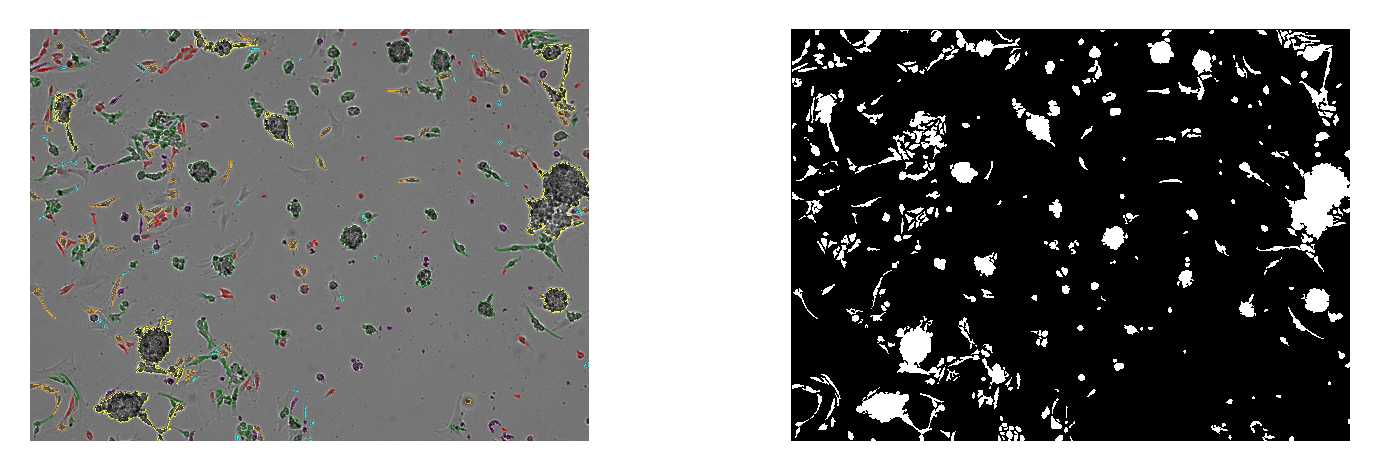

Image 30:


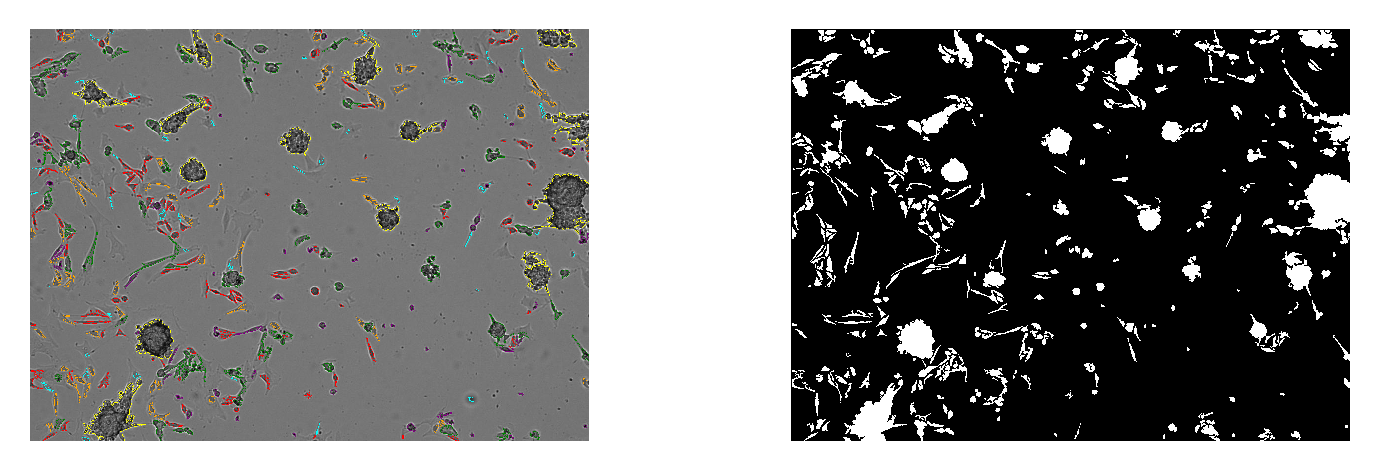

Image 45:


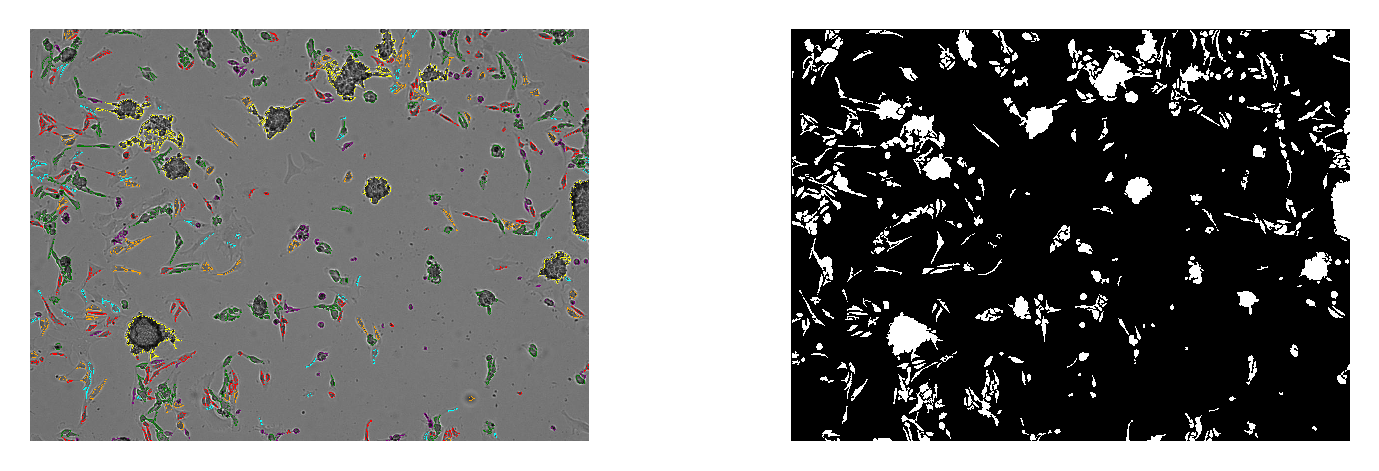

Image 60:


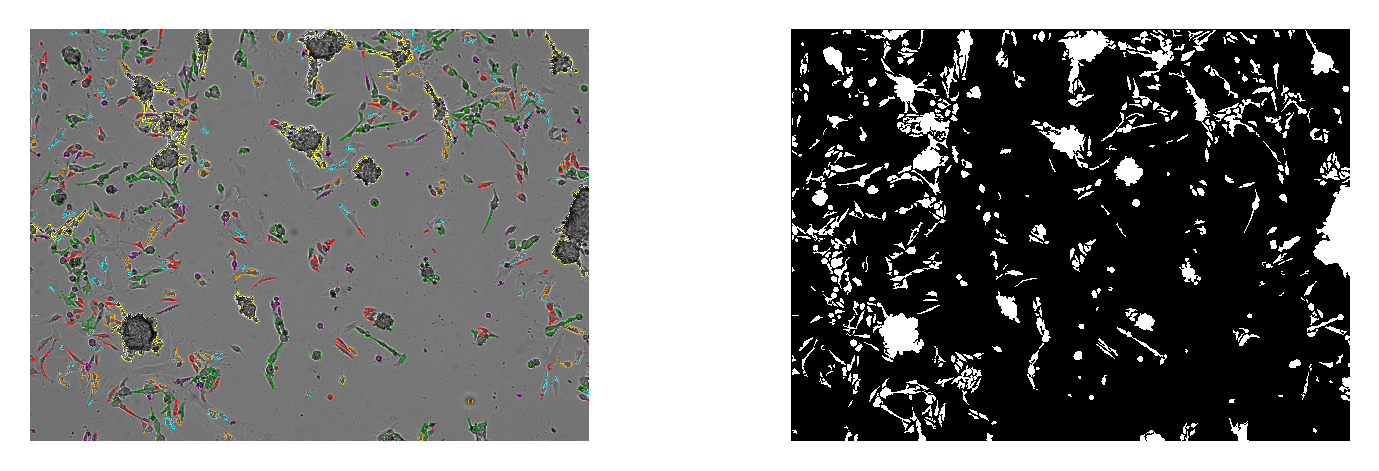

Image 75:


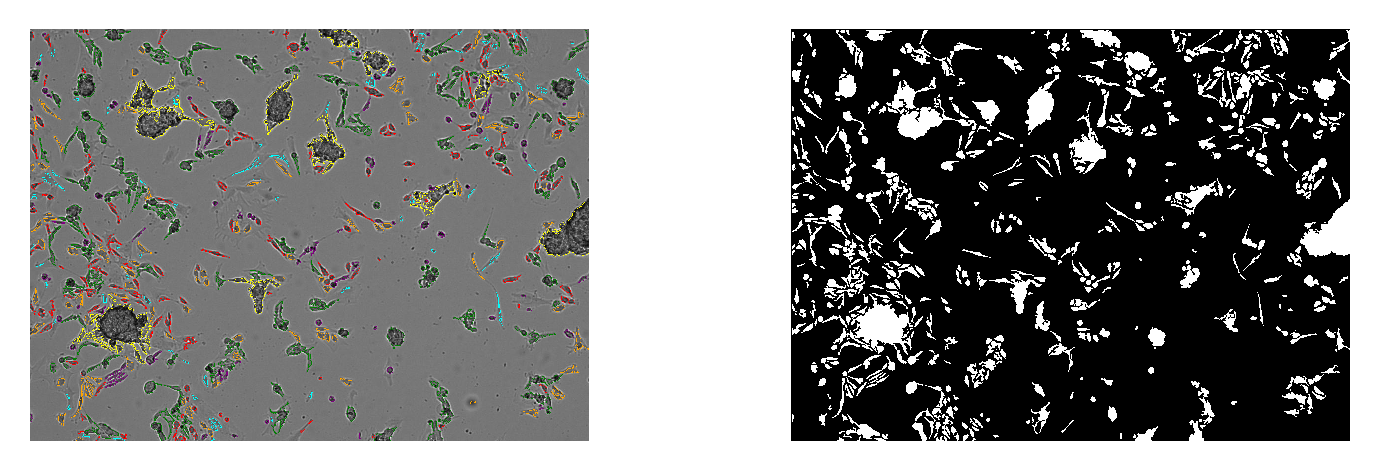

Image 90:


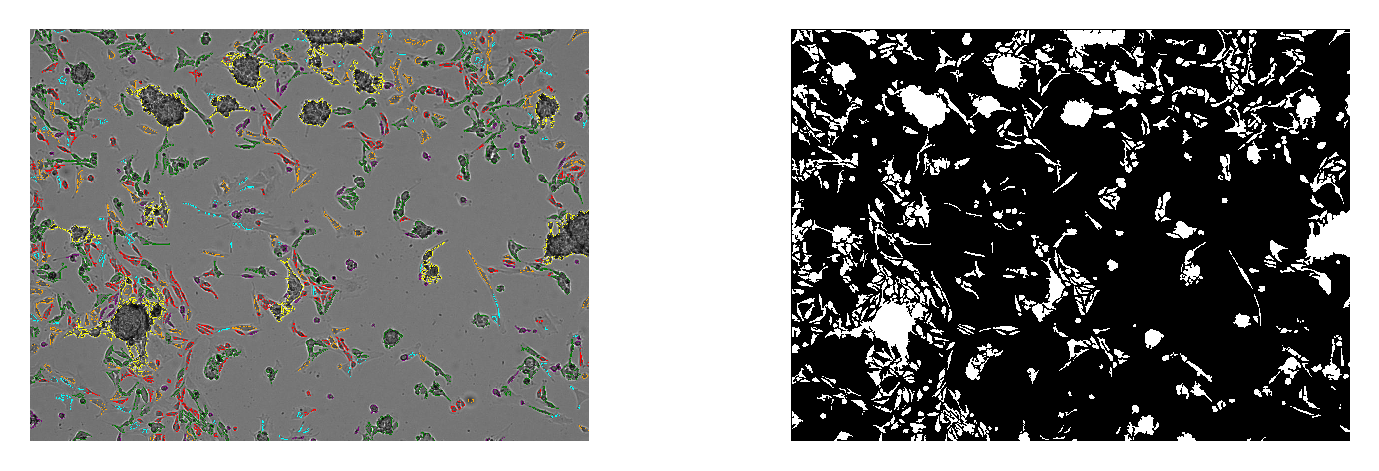

Image 105:


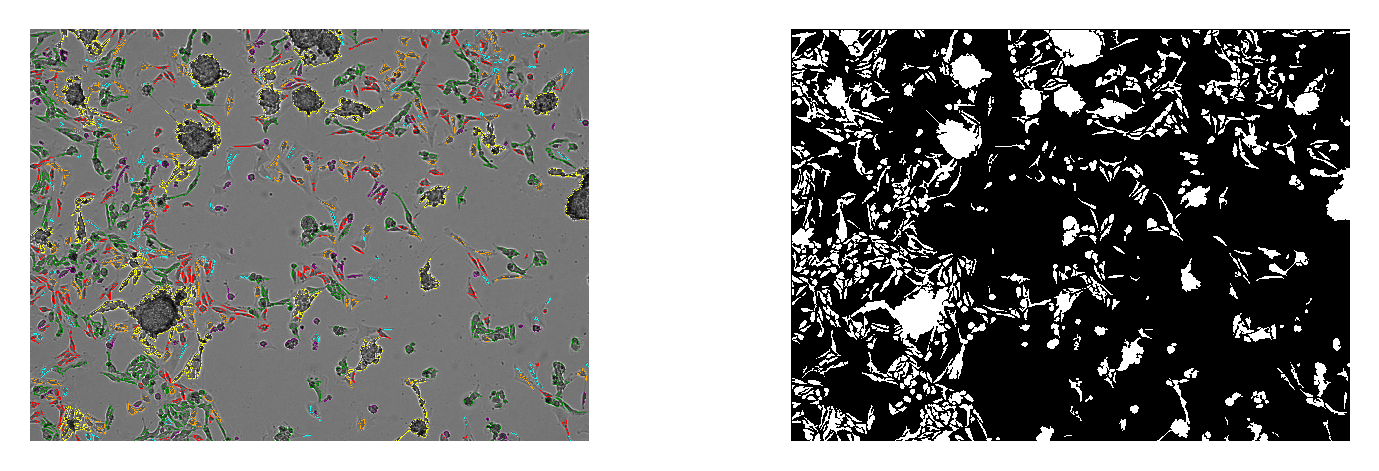

Image 120:


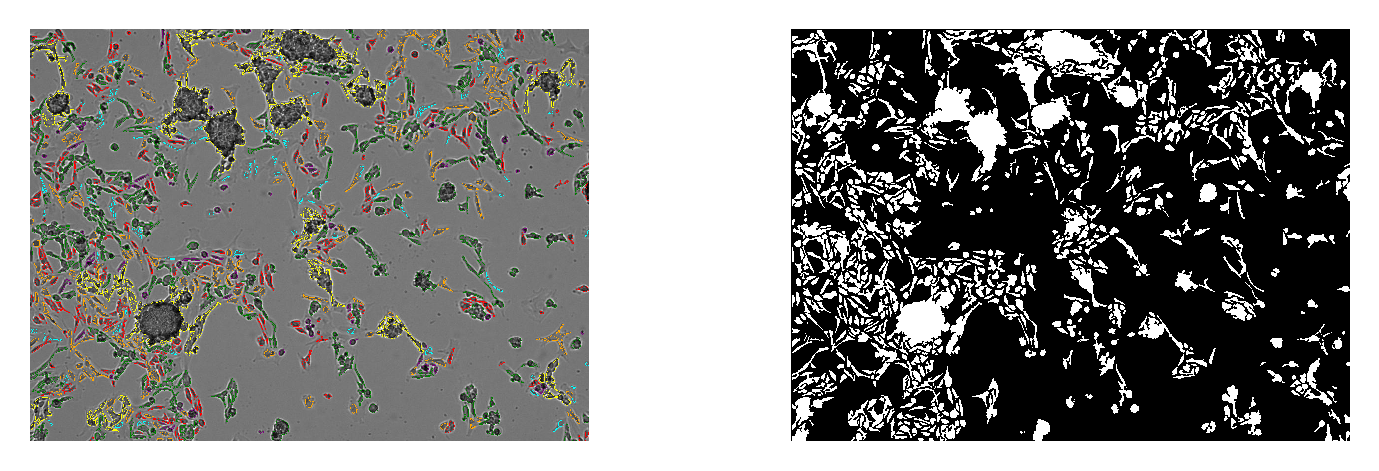

Image 135:


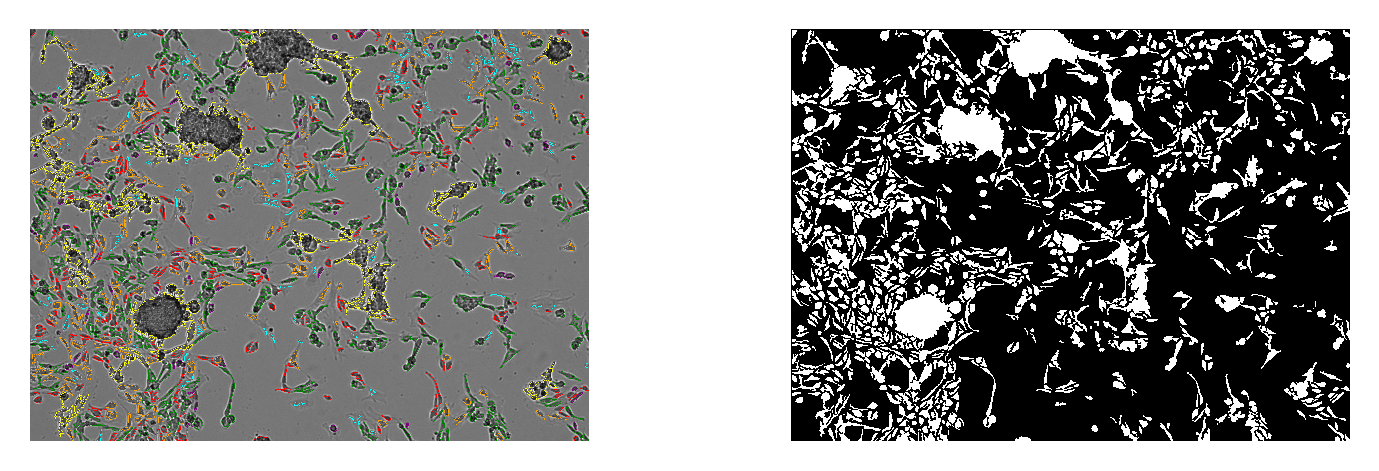

In [20]:
counts = []
total_sizes = []
mean_sizes = []
intensities_1 = []
intensities_2 = []

gif_buffer = []

# for every image in the image stack
for i in range(len(result)):
    df, mask_labels = result[i]

    # Preprocess features
    df = pd.DataFrame(pca.transform(scaler.transform(df)), index=df.index)
    
    # Cluster using k-means
    labels = kmeans.predict(df)
    
    # Count classes
    counts += [[a[1] for a in sorted(Counter(labels).items(), key=lambda a: a[0])],]

    # Extract size & fluorescence data
    # NOTE: This step is parallelized since it's most computationally expensive by far, due
    # to the mask generation. This cuts down runtime by ~55%. We can consider parallelizing
    # by image frame but we'll have to look into copying sklearn models. We can also nest
    # generators for args rather than making identical copies of images but the number of
    # copies is small enough that this shouldn't be an important issue.
    nc = kmeans.get_params()['n_clusters']
    args = zip(range(nc), [labels]*nc, [mask_labels]*nc)
#     args = zip(range(nc), [labels]*nc, [mask_labels]*nc, [fluor_images_1[i]]*nc,
#                [fluor_images_2[i]]*nc, [max_1]*nc, [max_2]*nc)
    fl_result = Parallel(n_jobs=cpu_count())(delayed(esf_parallel)(*a) for a in args)
    fl_result = np.array(fl_result, dtype=object)
    total_sizes += [fl_result[:,0],]
    mean_sizes += [fl_result[:,1],]
#     intensities = np.array([_ for _ in fl_result[:,2]], dtype=int)
#     intensities_1 += [intensities[:,0,:],]
#     intensities_2 += [intensities[:,1,:],]

    # Save for GIF creation
    contoured_image = get_contoured_image(gray_images[i], mask_labels, labels, colormap)
    gif_buffer.append(contoured_image)
    
    # Display sanity check images
    if i % 15 == 0:
        print("Image %i:" % i)
        display_image_array([contoured_image, np.uint8(mask_labels!=0)], columns=2, dpi=300)

counts = np.array(counts).T
total_sizes = np.array(total_sizes, dtype=int).T
mean_sizes = np.array(mean_sizes, dtype=int).T
# intensities_1 = np.swapaxes(np.array(intensities_1), 0, 1)
# intensities_2 = np.swapaxes(np.array(intensities_2), 0, 1)

## Save contoured images

In [21]:
imageio.mimsave('saved_images/contours/contours.gif', gif_buffer, duration=0.4)

for i in tqdm(range(len(gif_buffer))):
    imageio.imwrite(('saved_images/contours/%i.png' % i), gif_buffer[i])

## Plot class distributions

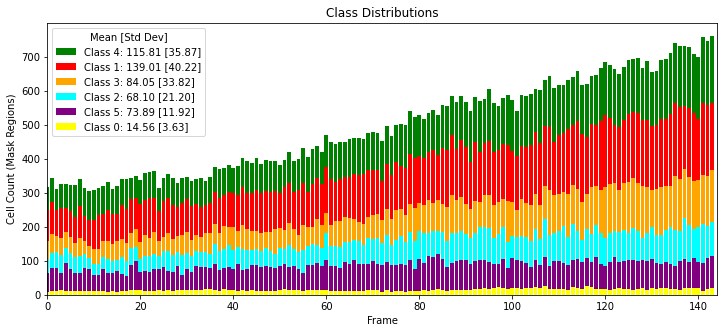

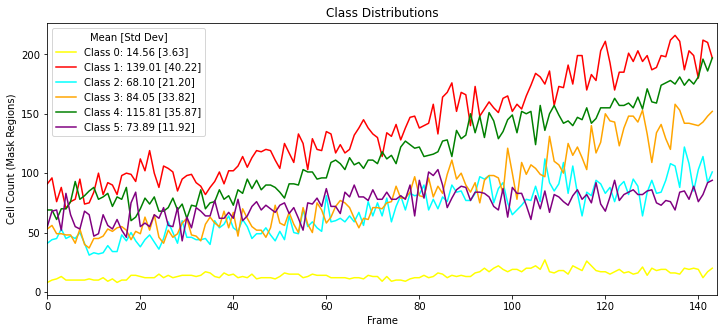

In [22]:
sorted_data = sorted(zip(counts, list(range(len(counts))),
                         np.mean(counts, axis=1), np.std(counts, axis=1)),
                     key=lambda a: a[0][-1])
bottom = np.zeros(counts.shape[1])
handles = []
plt.figure(figsize=(12,5))
plt.title("Class Distributions")
plt.ylabel("Cell Count (Mask Regions)")
plt.xlabel("Frame")
plt.xlim([0,len(sorted_data[0][0])])
for c, k, _, _ in sorted_data:
    handles += [plt.bar(range(len(c)), c, bottom=bottom, color=colormap.colors[k]),]
    bottom += c
plt.legend(reversed(handles),
           [("Class %i: %.2f [%.2f]" % a[1:]) for a in reversed(sorted_data)],
           title="Mean [Std Dev]")
plt.show()

plt.figure(figsize=(12,5))
plt.title("Class Distributions")
plt.ylabel("Cell Count (Mask Regions)")
plt.xlabel("Frame")
plt.xlim([0,len(sorted_data[0][0])])
for k in range(len(counts)):
    plt.plot(counts[k], color=colormap.colors[k],
             label=("Class %i: %.2f [%.2f]" % (k, np.mean(counts[k]), np.std(counts[k]))))
plt.legend(title="Mean [Std Dev]")
plt.show()

## Plot class sizes

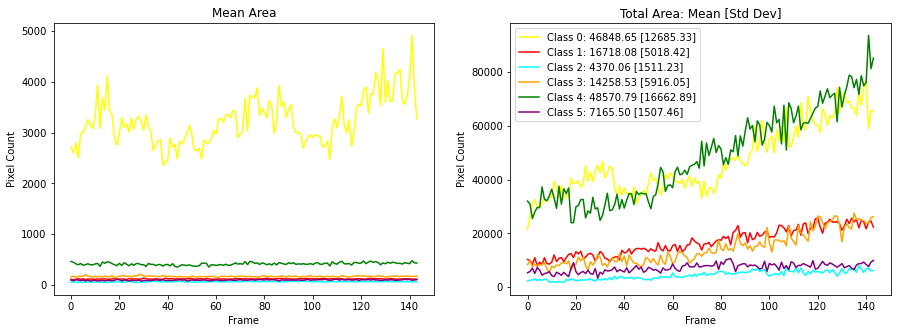

In [23]:
meanstd = list(zip(np.mean(total_sizes, axis=1), np.std(total_sizes, axis=1)))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

ax1.set_title("Mean Area")
ax1.set_ylabel("Pixel Count")
ax1.set_xlabel("Frame")
for k in range(len(mean_sizes)):
    ax1.plot(mean_sizes[k], color=colormap.colors[k], label=("Class %i" % k))

ax2.set_title("Total Area: Mean [Std Dev]")
ax2.set_ylabel("Pixel Count")
ax2.set_xlabel("Frame")
for k in range(len(total_sizes)):
    ax2.plot(total_sizes[k], color=colormap.colors[k],
             label=("Class %i: %.2f [%.2f]" % (k, *meanstd[k])))
ax2.legend()

plt.show()

## Plot fluorescence heatmaps

We plot raw counts of pixels here. We can also plot % of pixels (within the class area) using the code below but that gives us a visually near-identical heatmap.
```
prop_1 = np.divide(intensities_1, np.expand_dims(total_sizes, 2))
prop_2 = np.divide(intensities_2, np.expand_dims(total_sizes, 2))
```

In [24]:
# fig, axs = plt.subplots(intensities_1.shape[0], 2, figsize=(17,20))
# axs[0,0].set_title("Fluorescence %i" % 1)
# axs[0,1].set_title("Fluorescence %i" % 2)

# for i in range(intensities_1.shape[0]):
#     # Adding 1 here is a hacky trick to avoid taking the log of 0
#     sns.heatmap(intensities_1[i].T+1, ax=axs[i,0], norm=matplotlib.colors.LogNorm())
#     sns.heatmap(intensities_2[i].T+1, ax=axs[i,1], norm=matplotlib.colors.LogNorm(),
#                 cbar_kws={'label': "Pixel Count"})
#     axs[i,0].set_ylabel(("Class %i\nPixel Intensity" % i), size='large')
#     axs[i,0].invert_yaxis()
#     axs[i,1].invert_yaxis()
#     if i == intensities_1.shape[0]-1:
#         axs[i,0].set_xlabel("Frame")
#         axs[i,1].set_xlabel("Frame")

## Plot fluorescence percentiles

In [25]:
# def get_perc_val_from_counts(counts, percentile):
#     pidx = int(sum(counts) * percentile / 100)
#     for i in range(len(counts)):
#         if pidx > counts[i]:
#             pidx -= counts[i]
#         else:
#             return i

# def plot_fluorescence(intensities_1, intensities_2, percentile=50):
#     perc_values_1 = np.zeros((intensities_1.shape[1], intensities_1.shape[0]))
#     for i in range(intensities_1.shape[1]):
#         perc_values_1[i] = list(map(get_perc_val_from_counts,
#                                     intensities_1[:,i,:], [percentile]*len(intensities_1)))
#     perc_values_1 = perc_values_1.T

#     perc_values_2 = np.zeros((intensities_2.shape[1], intensities_2.shape[0]))
#     for i in range(intensities_2.shape[1]):
#         perc_values_2[i] = list(map(get_perc_val_from_counts,
#                                     intensities_2[:,i,:], [percentile]*len(intensities_2)))
#     perc_values_2 = perc_values_2.T

#     plt.figure(figsize=(15, 5))
#     for i in range(len(perc_values_1)):
#         plt.subplot(1,2,1)
#         plt.plot(perc_values_1[i], color=colormap.colors[i])
#         plt.title("Fluorescence 1 - %ith Percentile" % percentile)
#         plt.ylabel("Pixel Intensityß")
#         plt.xlabel("Frame")
#         plt.ylim(0, 40)

#         plt.subplot(1,2,2)
#         plt.plot(perc_values_2[i], color=colormap.colors[i])
#         plt.title("Fluorescence 2 - %ith Percentile" % percentile)
#         plt.xlabel("Frame")
#         plt.ylim(0, 40)
#     plt.show()

# plot_fluorescence(intensities_1, intensities_2, 95)
# plot_fluorescence(intensities_1, intensities_2, 99)